In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss

Kf = KFold(n_splits=5, random_state=42, shuffle=True)

pd.options.mode.chained_assignment = None  # default='warn'


""" Jupyter
# Display plots in the notebook
#%matplotlib inline 

# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 17
"""


def split_gen(col, data):# Seperating out listing with salary info
    """[Generates train/test splits of data with Given salaries as determined by the target given as col]

    Args:
        col ([string]): [our y target]
        data ([DataFrame]): [munged data]

    Returns:
        [tuple]: [train and test splits]
    """
    salary_data = data[data[col].notnull()]
    # Seperating out listing with salary info.
    sal_X = salary_data[['JobTitle', 'City', 'State', 'Company', 'Requirements', 'Summary', 'Description']]
    sal_X.reset_index(drop=True, inplace=True)

    # Using col to designate the target vector.
    sal_y = pd.DataFrame(salary_data[col])
    sal_y.reset_index(drop=True, inplace=True)

    X_train, X_test, y_train, y_test = train_test_split(sal_X, sal_y, train_size=.8, test_size=0.2, stratify=sal_y, random_state=42) 

    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
    return X_train, X_test, y_train, y_test

### Splitting Data
We're using linear regression to predict missing salary data so each posting can be classified into a range. Using the summary statistics of the subset of data that did have salary information I created four salary ranges, represented as Q1, Q2, Q3, and Q4 to represent the quartiles of the range of given salaries.



I've used the quartiles, the data in each 25% increment I use the median, first, and third quartiles of the subset of data with given salaries to create splits in my data for each quartetile along the binary truth of each range. 

In [2]:
def rl(col, data):
    """[Performs the full ML process for RL with tfid. To generate predictions for each quartile
    of the given salaries this function is called for each vector representing the quartile the
    salaries are in.]

    Args:
        col ([string]): [our target]
        data ([DataFrame]): [munged data]

    Returns:
        [csv]: [table containing data plus predictions for each quartile of all
        given salaries for that range.]
    """

    X_train, X_test, y_train, y_test = split_gen(col, data)
    def tfid_words(feature):
        """[Builds word/phrase lists and provides numeric values for their frequency.]

        Args:
            feature ([string]): [features containing string values that can be processed using tfid]

        Returns:
            [list]: [full list of words and phrases]
        """
        tvec_feature = TfidfVectorizer(stop_words="english", ngram_range=(1, 2), min_df=0.03)
        tvec_feature.fit(X_train[feature])
        feature_train = pd.DataFrame(tvec_feature.transform(X_train[feature]).todense(),
                           columns=tvec_feature.get_feature_names())
        word_counts = feature_train.sum(axis=0)
        word_counts.sort_values(ascending = False)
    
    
        return word_counts.sort_values(ascending = False), tvec_feature
    
    def top_bottom_wordstfid(feature, good=False):
        """[Collects the most and least used words and phrases]

        Args:
            feature ([col vector]): [features containing string values that can be processed using tfid]
            good (bool, optional): [Allows for setting which end of the current table to build list
            from based on a percentage.]. Defaults to False.

        Returns:
            [list]: [The top or bottom x percent as needed]
        """
        _percent = int(len(tfid_words(feature)[0])*.4)
        if good == True:
            words_out = tfid_words(feature)[0][:_percent]
        else:
            words_out = tfid_words(feature)[0][-_percent:]
        return words_out, tfid_words(feature)[1]
    
    # each of the below is a tuple, the first position going to the binomial
    # feature set, while the 2nd position contains the tfid vector needed for 
    # that feature set.
    top_JobTitles_tfid = top_bottom_wordstfid('JobTitle', good=True)
    bottom_JobTitles_tfid = top_bottom_wordstfid('JobTitle', good=False)
    
    top_Cities_tfid = top_bottom_wordstfid('City', good=True)
    bottom_Cities_tfid = top_bottom_wordstfid('City', good=False)
    
    top_States_tfid = top_bottom_wordstfid('State', good=True)
    bottom_States_tfid = top_bottom_wordstfid('State', good=False)
    
    top_Companies_tfid = top_bottom_wordstfid('Company', good=True)
    bottom_Companies_tfid = top_bottom_wordstfid('Company', good=False)
    
    top_Requirements_tfid = top_bottom_wordstfid('Requirements', good=True)
    bottom_Requirements_tfid = top_bottom_wordstfid('Requirements', good=False)
    
    top_Summaries_tfid = top_bottom_wordstfid('Summary', good=True)
    bottom_Summaries_tfid = top_bottom_wordstfid('Summary', good=False)
    
    top_Descriptions_tfid = top_bottom_wordstfid('Description', good=True)
    bottom_Descriptions_tfid = top_bottom_wordstfid('Description', good=False)
    
    
    # TODO Be able to detect strong correlations, then tune or remove features as need.
    # This may very well be necessary since both sets of new features are drawn from
    # same original features
    # The same tfid feature set is the same between both top_feature/bottom_feature tuples
    
    def tfid_features(split):
        """[Uses the word/phrase lists generated to generate predictive values for each
        table of data (split) under consideration.
        For future analysis, it 'may' help to add ]

        Args:
            split ([DataFrame]): [test train or unseen data]

        Returns:
            [DataFrame]: [Now with tfid features with float values]
        """
        jobTitle_X = pd.DataFrame(top_JobTitles_tfid[1].transform(split["JobTitle"]).todense(),
                                        columns=top_JobTitles_tfid[1].get_feature_names())
        
        City_X = pd.DataFrame(top_Cities_tfid[1].transform(split["City"]).todense(),
                                        columns=top_Cities_tfid[1].get_feature_names())
        
        State_X = pd.DataFrame(top_States_tfid[1].transform(split["State"]).todense(),
                                       columns=top_States_tfid[1].get_feature_names())
        
        Company_X = pd.DataFrame(top_Companies_tfid[1].transform(split["Company"]).todense(),
                                       columns=top_Companies_tfid[1].get_feature_names())
        
        Requirements_X = pd.DataFrame(top_Requirements_tfid[1].transform(split["Requirements"]).todense(),
                                       columns=top_Requirements_tfid[1].get_feature_names())
    
        Summary_X = pd.DataFrame(top_Summaries_tfid[1].transform(split["Summary"]).todense(),
                                       columns=top_Summaries_tfid[1].get_feature_names())
    
        Description_X = pd.DataFrame(top_Descriptions_tfid[1].transform(split["Description"]).todense(),
                                        columns=top_Descriptions_tfid[1].get_feature_names())
        split = pd.concat([split, jobTitle_X, City_X, State_X, Company_X, Requirements_X, Summary_X, Description_X], axis=1)
        
        return split
    
    def binary_features(split): 
        """[Uses the tfid word lists to provide binary features for each data]

        Args:
            split ([DataFrame]): [test train or unseen data]

        Returns:
            [DataFrame]: [Now with binary features as binary values]
        """
        # each of the below is a tuple, the first position going to the binomial
        # feature set, while the 2nd position contains the tfid vector needed for 
        # that feature set.
        split["top_JobTitle"] = 0
        for key in top_JobTitles_tfid[0].keys():
            split.loc[(split["JobTitle"].str.contains(f"{key}")), "top_JobTitle"] = 1
        split["bottom_JobTitle"] = 0
        for key in bottom_JobTitles_tfid[0].keys():
            split.loc[(split["JobTitle"].str.contains(f"{key}")), "bottom_JobTitle"] = 1
        split["top_City"] = 0
        for key in top_Cities_tfid[0].keys():
            split.loc[(split["City"].str.contains(f"{key}")), "top_City"] = 1
        split["bottom_City"] = 0
        for key in bottom_Cities_tfid[0].keys():
            split.loc[(split["City"].str.contains(f"{key}")), "bottom_City"] = 1
        split["top_state"] = 0
        for key in top_States_tfid[0].keys():
            split.loc[(split["State"].str.contains(f"{key}")), "top_state"] = 1
        split["bottom_state"] = 0
        for key in bottom_States_tfid[0].keys():
            split.loc[(split["State"].str.contains(f"{key}")), "bottom_state"] = 1
        split["top_company"] = 0
        for key in top_Companies_tfid[0].keys():
            split.loc[(split["Company"].str.contains(f"{key}")), "top_company"] = 1
        split["bottom_compay"] = 0
        for key in bottom_Companies_tfid[0].keys():
            split.loc[(split["Company"].str.contains(f"{key}")), "bottom_compay"] = 1
        split["top_requirements"] = 0
        for key in top_Requirements_tfid[0].keys():
            split.loc[(split["Requirements"].str.contains(f"{key}")), "top_requirements"] = 1
        split["bottom_reqirements"] = 0
        for key in bottom_Requirements_tfid[0].keys():
            split.loc[(split["Requirements"].str.contains(f"{key}")), "bottom_reqirements"] = 1
        split["top_summary"] = 0
        for key in top_Summaries_tfid[0].keys():
            split.loc[(split["Summary"].str.contains(f"{key}")), "top_summary"] = 1
        split["bottom_summary"] = 0
        for key in bottom_Summaries_tfid[0].keys():
            split.loc[(split["Summary"].str.contains(f"{key}")), "bottom_summary"] = 1
        split["top_description"] = 0
        for key in top_Descriptions_tfid[0].keys():
            split.loc[(split["Description"].str.contains(f"{key}")), "top_description"] = 1
        split["bottom_description"] = 0
        for key in bottom_Descriptions_tfid[0].keys():
            split.loc[(split["Description"].str.contains(f"{key}")), "bottom_description"] = 1
        
        # dropping these data columns leaves only the predictive features.
        split.drop(['JobTitle', 'City', 'State', 'Company', 'Requirements', 'Summary', 'Description'], axis=1, inplace=True)
        # TODO get rid of this.
        # Converting 1 and 0 values in matrix to float
        split = split.astype("float")
        return split


    # The crux of the rl function is that it contains each of our splits and
    # operates on each in sequence.
    
    ### TRAINING
    # Train: Featurizing 
    X_train = tfid_features(X_train)
    X_train = binary_features(X_train)
    
    # Initializing model and setting hyperparameters
    C_list = np.logspace(1e-5, 1e5, num=30)
    log_reg = LogisticRegressionCV(random_state=42, Cs = C_list, solver='saga', cv=Kf, max_iter=10000) ####
    
    # Train: Fitting model to our data
    log_reg.fit(X_train, y_train.values.ravel())
    
    # Train: Evaluating
    y_train = y_train.to_numpy().flatten()
    train_score = log_reg.score(X_train, y_train)
    
    # Train: Predictions
    y_pred = log_reg.predict(X_train)
    y_train_probas = log_reg.predict_proba(X_train)
    
    # Log Loss Function
    train_log_loss = log_loss(y_train, y_train_probas)
    

    
    
    ### TESTING
    # Test: Featurizing
    X_test = tfid_features(X_test)
    X_test = binary_features(X_test)
    
    # Test: Evaluating
    y_test = y_test.to_numpy().flatten()
    test_score = log_reg.score(X_test, y_test)
    
    # Test: Predictions
    y_test_preds = log_reg.predict(X_test) 
    y_test_probas = log_reg.predict_proba(X_test)
    
    # Log Loss Function
    test_log_loss = log_loss(y_test, y_test_probas)
    
    # Test: Confusion
    confusion = confusion_matrix(y_test, y_test_preds)
    
    # Test: Optimal C
    optC = log_reg.C_
    class_report = classification_report(y_train,y_pred)


    
    ### Dummy!
    dummy = DummyClassifier(strategy='most_frequent')
    dummy.fit(X_train, y_train)
    dummy_score = dummy.score(X_test, y_test)
    dummy_probas = dummy.predict_proba(X_test) 
    dummy_log_loss = log_loss(y_test,dummy_probas)
    

    
    

    ### PREDICTIONS
    # Much as before, where the target is selected given a string representing the particular
    # quartile we are interested in, except now using a table where the values in our target are null.
    predict_data = data[data[col].isnull()]
    predict_data.reset_index(drop=True, inplace=True)
    
    # Splitting out our predictor variables from the salary data
    predict_X = predict_data[['JobTitle', 'City', 'State', 'Company', 'Requirements', 'Summary', 'Description']]
    predict_X.reset_index(drop=True, inplace=True)
    predict_X.head()
    
    # Predictions: Featurizing
    predict_X = tfid_features(predict_X)
    predict_X = binary_features(predict_X)
    
    
    predict_y = log_reg.predict(predict_X)
    predict_probas = log_reg.predict_proba(predict_X) 
    predict_log_loss = log_loss(predict_y, predict_probas)
    
    predict_class_reports = classification_report(y_train,y_pred)
    
    
    # Attaching the predictions as a new column in the table.
    predict_data[f'{col}_Pred'] = predict_y
    
    # The predict_proba method generates a list of tuples, each representing the binary probabilities for
    # each of the 0.0 and 1.0 labels in the target variable. By taking the probability associated with the
    # prediction (the larger of the two) I'll be able to show this information for each job posting.
    probabilities = []
    for i in predict_probas:
        if i[0]>i[1]:
            probabilities.append(round(i[0],2))
        else:
            probabilities.append(round(i[1],2))
            
    
    predict_data[f'{col}_Prob'] = probabilities
    
    

    
    # Finally, combing our data that had given salaries, with the data we had
    # to predict salary ranges for.
    # This table is then reused as the rl function is called for each target we're interested in.
    given_sal = data[data[col].notnull()]
    lst = [predict_data, given_sal]

    new_data = pd.concat(lst)
    
    
    def tfid_importance(table,y_predict):
        X = table
        y = y_predict
        y = y.astype(int)
    
        clf = DecisionTreeClassifier(random_state=42, criterion = 'entropy', max_depth = 10)
        clf.fit(X,y)
        ft_col = []
        fi = []

        for i, column in enumerate(table):
        # print(f'The feat. importance of {column} is: {clf.feature_importances_[i]}')
            ft_col.append(column)
            fi.append(clf.feature_importances_[i])
    
        fi_df = zip(ft_col, fi)
        fi_df = pd.DataFrame(fi_df, columns = ['Feature', 'Importance'])
        most_important = fi_df[fi_df['Importance'] > 0]
        return most_important
    
    
    most_important = tfid_importance(predict_X,predict_y)
    #return new_data
    return new_data, train_score, y_train_probas, train_log_loss, test_score, y_test_probas, test_log_loss, confusion, optC, class_report, dummy_score, dummy_probas, dummy_log_loss, predict_probas, predict_log_loss, predict_class_reports, most_important
    #return predict_data,predict_X, predict_y, predict_probas, predict_log_loss, given_sal


def summary_rl():
    """[Performs the full ML process for RL with tfid. To generate predictions for each quartile
    of the given salaries this function is called for each vector representing the quartile the
    salaries are in.]

    Args:
        col ([string]): [our target]
        data ([DataFrame]): [munged data]

    Returns:
        [csv]: [table containing data plus predictions for each quartile of all
        given salaries for that range.]
    """
    data = pd.read_csv('../data/munged_data.csv')
    data.reset_index(drop=True, inplace=True)

    # Some tidy that can't seem to happen in Munge...

    data['State'].replace(np.nan, '', regex=True, inplace=True)
    data['City'].replace(np.nan, '', regex=True, inplace=True)

    # EDA: Stats
    # TODO compute and utlize IQR etc in order to stratify analysis further
    # print("salary median: " + str(data["Salary"].median()))
    # print("salary mean: " + str(data["Salary"].mean()))
    # print(data.describe())

    # Creation of targets baseed on our munged data's summary stats.
    salary_data = data[data.Salary.notnull()]
    Q1, Q2, Q3 = np.percentile(salary_data.Salary,[25, 50, 75])
    iqr = Q3-Q1
    out_below = Q1-(1.5*iqr)
    out_above = Q3+(1.5*iqr)
    
    data["Q1"] = np.nan
    data["Q2"] = np.nan
    data["Q3"] = np.nan
    data["Q4"] = np.nan

    
    
    data.loc[(data.Salary >= out_below) & (data.Salary <= Q1), "Q1"] = 1.0
    data.loc[(data.Salary < out_below) | (data.Salary > Q1), "Q1"] = 0.0

    data.loc[(data.Salary >= Q1) & (data.Salary < Q2), "Q2"] = 1.0
    data.loc[(data.Salary < Q1) | (data.Salary >= Q2), "Q2"] = 0.0

    data.loc[(data.Salary >= Q2) & (data.Salary < Q3), "Q3"] = 1.0
    data.loc[(data.Salary < Q2) | (data.Salary >= Q3), "Q3"] = 0.0

    data.loc[(data.Salary >= Q3) & (data.Salary <= out_above), "Q4"] = 1.0
    data.loc[(data.Salary < Q3) | (data.Salary > out_above), "Q4"] = 0.0
    
    
    data.loc[data.Salary < out_below, "out_above"] = 1.0
    data.loc[data.Salary > out_below, "out_above"] = 0.0


    # Drawing out performance metrics and results for each target.
    # Results are then passed into subsequent ML function calls
    col = 'Q1'
    Q1, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12, m13, m14, m15, m_words = rl(col, data)

    col = 'Q2'
    Q2, i1, i2, i3, i4, i5, i6, i7, i8, i9, i10, i11, i12, i13, i14, i15, i_words = rl(col, Q1)

    col = 'Q3'
    Q3, l1, l2, l3, l4, l5, l6, l7, l8, l9, l10, l11, l12, l13, l14, l15, l_words = rl(col, Q2)

    col = 'Q4'
    final, h1, h2, h3, h4, h5, h6, h7, h8, h9, h10, h11, h12, h13, h14, h15, h_words = rl(col, Q3)

    # Grouping metrics into groups for further analysis and comparison
    tr_scores = [m1, i1, l1, h1]
    tr_probs = [m2, i2,l2, h2]
    tr_logloss = [m3, i3, l3, h3]
    
    te_scores = [m4, i4, l4, h4]
    te_probs = [m5, i5, l5, h5]
    te_logloss = [m6, i6, l6, h6]
    
    confusions = [m7, i7, l7, h7]
    optC = [m8, i8, l8, h8]
    tr_class_reports = [m9, i9, l9, h9]
    
    dum_scores = [m10, i10, l10, h10]
    dum_probs = [m11, i11, l11, h11]
    dum_logloss = [m12, i12, l12, h12]
    
    pr_probs = [m13, i13, l13, h13]
    pr_logloss = [m14, i14, l14, h14]
    pr_class_reports = [m15, i15, l15, h15]
    
    
    metrics = [tr_scores, tr_probs, tr_logloss, te_scores, te_probs, te_logloss, confusions, optC, tr_class_reports, dum_scores, dum_probs, dum_logloss, pr_probs, pr_logloss, pr_class_reports]
    words = [m_words, i_words, l_words, h_words]
    
    # adding tite capitalization so each targets most impactful words can be shared with the user in a wordcload
    for i in range(4):
        words[i].Feature = words[i].Feature.str.capitalize()
    final.to_csv('../data/ml.csv', index=False)
    return final, words, metrics
    #return predict_data,predict_X, predict_y, predict_probas, predict_log_loss, given_sal

In [3]:
data, words, metrics = summary_rl()

/home/kenji/.local/lib/python3.8/site-packages/numpy/core/function_base.py:265: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)
/home/kenji/.local/lib/python3.8/site-packages/numpy/core/function_base.py:265: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)
/home/kenji/.local/lib/python3.8/site-packages/numpy/core/function_base.py:265: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)
/home/kenji/.local/lib/python3.8/site-packages/numpy/core/function_base.py:265: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)


In [4]:
# number of predictions for each quantile
a = len(data[data.Q1_Pred == 1])
b = len(data[data.Q2_Pred == 1])
c = len(data[data.Q3_Pred == 1])
d = len(data[data.Q4_Pred == 1])
print(f'{a} predictions for Q1')
print(f'{b} predictions for Q2')
print(f'{c} predictions for Q3')
print(f'{d} predictions for Q4')
print(sum([a,b,c,d]))

638 predictions for Q1
455 predictions for Q2
431 predictions for Q3
1554 predictions for Q4
3078


In [5]:
Q = ['Q1','Q2', 'Q3', 'Q4']
training_class_reports = metrics[8]
for i,j in zip(Q,training_class_reports):
    print(f'{i} Training Class Report')
    print(j)

Q1 Training Class Report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       341
         1.0       1.00      1.00      1.00       119

    accuracy                           1.00       460
   macro avg       1.00      1.00      1.00       460
weighted avg       1.00      1.00      1.00       460

Q2 Training Class Report
              precision    recall  f1-score   support

         0.0       0.87      0.99      0.93       346
         1.0       0.97      0.54      0.69       114

    accuracy                           0.88       460
   macro avg       0.92      0.76      0.81       460
weighted avg       0.89      0.88      0.87       460

Q3 Training Class Report
              precision    recall  f1-score   support

         0.0       0.87      0.99      0.93       342
         1.0       0.97      0.57      0.72       118

    accuracy                           0.88       460
   macro avg       0.92      0.78      0.82       460

In [6]:
for i,j in zip(Q,metrics[14]):
    print(f'{i} Testing Class Reports')
    print(j)

Q1 Testing Class Reports
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       341
         1.0       1.00      1.00      1.00       119

    accuracy                           1.00       460
   macro avg       1.00      1.00      1.00       460
weighted avg       1.00      1.00      1.00       460

Q2 Testing Class Reports
              precision    recall  f1-score   support

         0.0       0.87      0.99      0.93       346
         1.0       0.97      0.54      0.69       114

    accuracy                           0.88       460
   macro avg       0.92      0.76      0.81       460
weighted avg       0.89      0.88      0.87       460

Q3 Testing Class Reports
              precision    recall  f1-score   support

         0.0       0.87      0.99      0.93       342
         1.0       0.97      0.57      0.72       118

    accuracy                           0.88       460
   macro avg       0.92      0.78      0.82       460

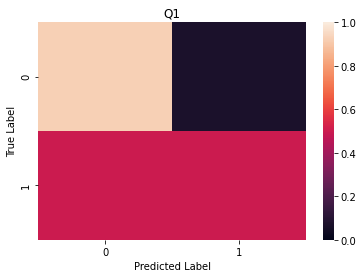

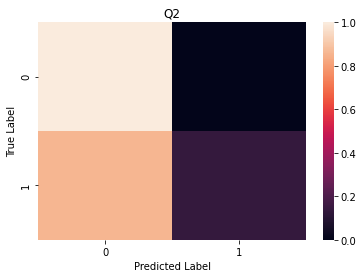

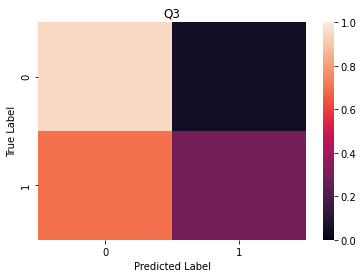

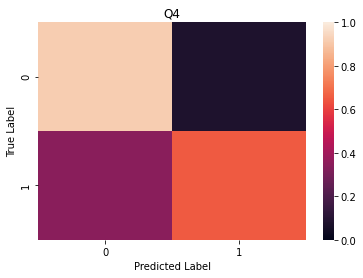

In [7]:
def confusion_matrices(cm,classes=None, title='Confusion Matrix'):
    if classes is None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
        plt.title(title)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

for i, j in zip(metrics[6], Q):
    cm = i
    cm_norm = cm / cm.sum(axis=1).reshape(-1,1)
    confusion_matrices(cm_norm, classes=[0,1], title=j)
    plt.show()

In [8]:
def word_importances():
    _, words, _ = summary_rl()
    binaries = ['Top_jobtitle', 'Bottom_jobtitle', 'Top_city', 'Bottom_city','Top_company', 'Bottom_company','Bottom_state','Top_company','Bottom_compay','Top_requirements','Bottom_reqirements','Top_summary','Bottom_summary','Top_description','Bottom_description','Target']
    states = ['Ak', 'Al','Ar','As','Az', 'Ca','Co','Ct','Dc','De','Fl','Ga','Gu','Hi','Ia','Id','Il','In','Ks','Ky','La','Ma','Md','Me','Mi','Mn','Mo','Ms','Mt','Nc','Nd','Ne','Nh','Nj','Nm','Nv','Ny','Oh','Ok','Or','Papr','Ri','Sc','Sd','Tn','Tx','Ut','Va','Vi','Vt','Wa','Wi','Wv', 'Wy']
    imp_words = []
    imp_states = []
    for _ in range(4):
        out = words[_][~words[_].Feature.isin(binaries)].sort_values(by='Importance', ascending=False).reset_index(drop=True)
        out = out[~out.Feature.isin(states)].sort_values(by='Importance', ascending=False).reset_index(drop=True)
        imp_words.append(out)
    for _ in range(4):
        out_state = words[_][words[_].Feature.isin(states)].sort_values(by='Importance', ascending=False).reset_index(drop=True)
        imp_states.append(out_state)

    # Providing labels to distinguish sets of terms in the output table
    Q1_w, Q2_w, Q3_w, Q4_w = imp_words
    Q1_w['Q'] = 'Q1'
    Q2_w['Q'] = 'Q2'
    Q3_w['Q'] = 'Q3'
    Q4_w['Q'] = 'Q4'
    
    Q1_w = Q1_w[:len(Q1_w)//2]
    Q2_w = Q2_w[:len(Q2_w)//2]
    Q3_w = Q3_w[:len(Q3_w)//2]
    Q4_w = Q4_w[:len(Q4_w)//2]
    term_sets = [Q1_w,Q2_w,Q3_w,Q4_w]

    
    # Concatenating each set of top terms into a single table
    top_terms = pd.concat(term_sets).reset_index(drop=True)

    # Setting up a capitalization function
    def state_fix():
        state_words = imp_states
        top_states = []
        for i in state_words:
            i.reset_index(drop=True, inplace=True)
            top_states.append(i)
        return top_states

    top_states = state_fix()
    Q1_s, Q2_s, Q3_s, Q4_s = top_states
    # Providing labels to distinguish sets of states in the output table
    Q1_s['Q'] = 'Q1'
    Q2_s['Q'] = 'Q2'
    Q3_s['Q'] = 'Q3'
    Q4_s['Q'] = 'Q4'
    
    # Concatenating each set of top states into a single table
    top_states = pd.concat([Q1_s,Q2_s,Q3_s,Q4_s]).reset_index(drop=True)
    # Applying the capitalization function
    top_states['Feature'] = top_states['Feature'].apply(lambda x: x.upper())
    
    top_terms.to_csv(f'../data/top_terms.csv', index=False)
    top_states.to_csv(f'../data/top_states.csv', index=False)
    return top_terms, top_states


imp_words, top_states = word_importances()

In [9]:
imp_words[imp_words.Q == 'Q1']

,Feature,Importance,Q
0,Analyst,0.116816,Q1
1,University,0.085195,Q1
2,Scientist,0.037744,Q1
3,Business,0.020403,Q1
4,Engineer,0.020017,Q1
5,Reinventing,0.018439,Q1
6,Work environment,0.017724,Q1
7,Analytics,0.014664,Q1
8,Office,0.012586,Q1
9,Culture,0.011854,Q1


In [10]:
#### ML Tuning Log:

b4 clist removal: 2155

added sag solver: 2155

added saga solver: 2155

added liblinear solver: 2155
- This one took a while

back to saga, with n_grams raised to max3: 2131
- at least the dial moved

It looks like this is the n_grams: 2155
- when back to max2

max_features=20 > 30: 2209
- we're getting somewhere

max_features=20 > 100: 2221

changing logpasce from 20 > 30: no change
- reverting

Dropping max features: 3190
- wow! dropping constraints is great

changing the cutoff from +/- 30% > 40%: 3186
- not worth the greatly increased processing time. Reverted

with min_df raised from .02 to .03: 3341

after a computer restart: 2678....
- noticed n_grams was 1,1

reverted n_grams to 1,2:

SyntaxError: invalid syntax (<ipython-input-10-1f91dbeab70d>, line 3)

In [ ]:
data